In [80]:
import os
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm import tqdm

from efficient_kan.kan import KAN
from kan_convolutional import KANLinear
from kan_convolutional.KANConv import KAN_Convolutional_Layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TRAININGSET + TESTSET DEFINITION

In [117]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
# Train set. Here we sort the MNIST by digits and disable data shuffling
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sorted_indices = sorted(range(len(train_dataset) // 1), key=lambda idx: train_dataset.targets[idx])
# sorted_indices = range(len(train_dataset)//10)
train_dataset = torch.utils.data.Subset(train_dataset, sorted_indices)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
# Test set
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(len(test_dataset) // 1))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# TRAIN() AND TEST() FUNCTIONS

In [112]:
def train(model, checkpoint, optimizer, epochs=5, on_epoch_end=None, lr=0):
    criterion = nn.CrossEntropyLoss()
    # scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.996)
    for epoch in range(epochs):
        model.train()
        loss = 0
        epoch_start = time.time_ns()
        with tqdm(train_loader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                    images = images.view(-1, 28 * 28)
                optimizer.zero_grad()
                output = model(images.to(device))
                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step(closure=lambda: loss)
                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])
                # scheduler.step()
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, loss.item(), epoch_duration, lr)
        torch.save(model.state_dict(), f'{checkpoint}_ep{epoch + 1}.pth')

In [110]:
def test(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    predictions = []
    ground_truths = []
    val_accuracy = 0
    loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big']:
                images = images.view(-1, 28 * 28)
            output = model(images.to(device))
            loss = criterion(output, labels.to(device))
            predictions.extend(output.argmax(dim=1).to('cpu').numpy())
            ground_truths.extend(labels.to('cpu').numpy())
            val_accuracy += (output.argmax(dim=1) == labels.to(device)).float().mean().item()
    val_accuracy /= len(test_loader)
    cm = confusion_matrix(ground_truths, predictions, labels=range(10))
    cmd = ConfusionMatrixDisplay(cm, display_labels=range(10))
    fig, ax = plt.subplots(figsize=(10, 10))
    cmd.plot(ax=ax)
    print(f"Accuracy: {val_accuracy}")
    return loss.item(), ground_truths, predictions

# ARCHITECTURES DEFINITION

In [6]:
# MLP
class MLP(nn.Module):
    def __init__(self, checkpoint: str | None = None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 28 * 28)
        self.fc2 = nn.Linear(28 * 28, 256)
        self.fc3 = nn.Linear(256, 10)
        if checkpoint:
            self.load_state_dict(torch.load(checkpoint))
            self.eval()

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [107]:
# KAN
class KAN_small(nn.Module):
    def __init__(self, device=device):
        super(KAN_small, self).__init__()
        self.model = KAN([28 * 28, 28 * 28, 128, 10]).to(device)

    def forward(self, x):
        return self.model(x)


class KAN_big(nn.Module):
    def __init__(self, device=device):
        super(KAN_big, self).__init__()
        self.model = KAN([28 * 28, 256, 10]).to(device)

    def forward(self, x):
        return self.model(x)

In [7]:
# KAN_Convolutional_Layer + MLP
class CKAN_BN(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn1 = nn.BatchNorm2d(5)

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )
        self.bn2 = nn.BatchNorm2d(25)

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [8]:
# KAN_Convolutional_Layer + MLP (without Batch Norm)
class KANC_MLP(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(625, 256)
        self.linear2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [9]:
# Conv2d + KAN
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Flatten layer
        self.flatten = nn.Flatten()

        # KAN layer
        self.kan1 = KANLinear(
            245,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [10]:
# Conv2d + MLP
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding='same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding='same')

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding='same')

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        #x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        #x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        #x = self.dropout3(x)
        x = self.fc2(x)

        #x = F.log_softmax(x, dim=1)
        return x

In [11]:
# KAN_Convolutional_Layer + KAN
class KKAN_Convolutional_Network(nn.Module):
    def __init__(self, device: str = device):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs=5,
            kernel_size=(3, 3),
            device=device
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.kan1 = KANLinear(
            625,
            10,
            grid_size=10,
            spline_order=3,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0, 1],
        )

    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)

        x = self.kan1(x)
        x = F.log_softmax(x, dim=1)

        return x

In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)

        return x


class SimpleCNN_2(nn.Module):
    def __init__(self):
        super(SimpleCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=0)
        self.conv2 = nn.Conv2d(5, 25, kernel_size=3, padding=0)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(625, 245)
        self.fc2 = nn.Linear(245, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)

        return x

# BATCH TESTS

In [106]:
class EpochStat:
    @staticmethod
    def loadModelStats(name) -> list['EpochStat']:
        return [pickle.load(open(f'checkpoint/stats/{file}', 'rb')) for file in
                filter(lambda e: name in e, os.listdir('checkpoint/stats/'))]

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr

    def save(self):
        pickle.dump(self, open(f'checkpoint/stats/{self.name}_epoch{self.epoch}.pickle', 'wb'))


def onEpochEnd(model, epoch, train_loss, epoch_duration, lr):
    test_loss, labels, predictions = test(model)
    stat = EpochStat(model.__class__.__name__, epoch, train_loss, test_loss, labels, predictions, epoch_duration, lr)
    stat.save()

Training model=KAN_small


100%|██████████| 938/938 [00:27<00:00, 34.15it/s, accuracy=0.344, loss=2.29, lr=1e-6] 


Epoch 1, Loss: 2.2885799407958984
Accuracy: 0.383359872611465


100%|██████████| 938/938 [00:27<00:00, 34.10it/s, accuracy=0.469, loss=2.28, lr=1e-6] 


Epoch 2, Loss: 2.2781691551208496
Accuracy: 0.529359076433121


100%|██████████| 938/938 [00:27<00:00, 34.35it/s, accuracy=0.438, loss=2.27, lr=1e-6] 


Epoch 3, Loss: 2.267195701599121
Accuracy: 0.5939490445859873


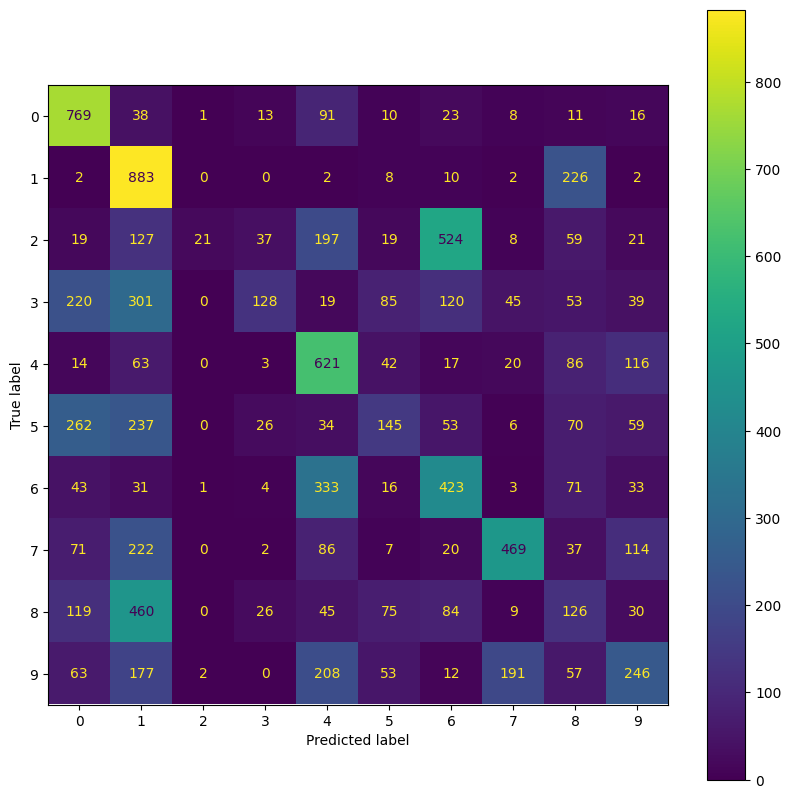

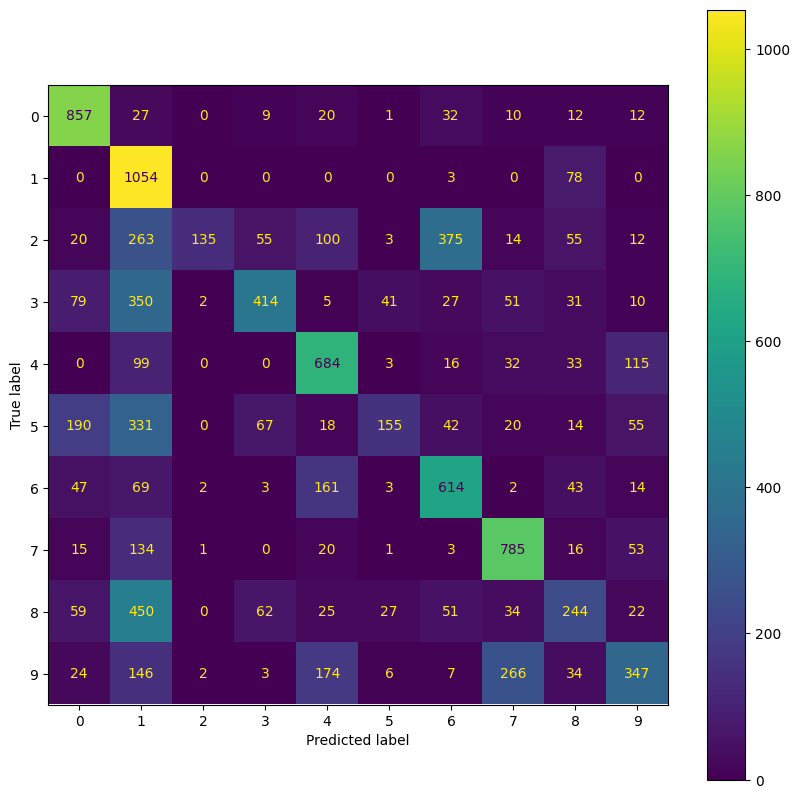

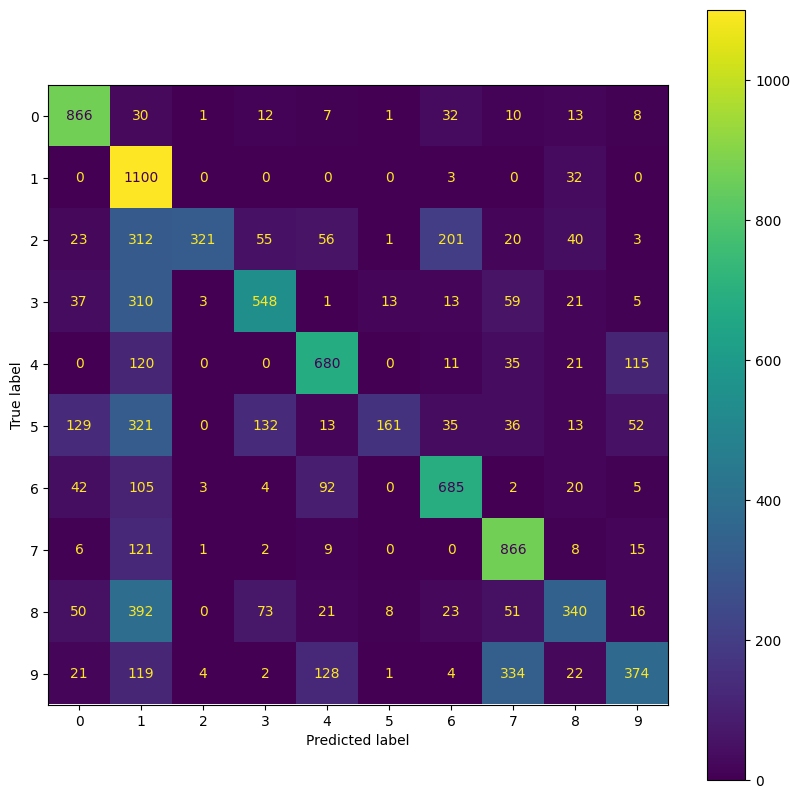

In [118]:
for model in [x.to(device) for x in [KAN_small()]
              # [MLP(), KAN_small(), KAN_big(),
              #  CKAN_BN(), KANC_MLP(), NormalConvsKAN(), ConvNet(),
              #  KKAN_Convolutional_Network(), SimpleCNN()]]:
              ]:
    print(f'Training model={model.__class__.__name__}')
    lr = 1e-6 if model.__class__.__name__ in ['MLP', 'KAN_small', 'KAN_big'] else 1e-4
    train(model, f'checkpoint/{model.__class__.__name__}', epochs=3,
          optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)

In [119]:
for stat in EpochStat.loadModelStats('KAN_small'):
    print(stat.train_loss, stat.test_loss, stat.epoch, stat.epoch_duration, )

2.2885799407958984 2.285999298095703 0 27468
2.2781691551208496 2.2666618824005127 1 27513
2.267195701599121 2.2464759349823 2 27306
